<a href="https://colab.research.google.com/github/JakobRobnik/MicroCanonicalHMC/blob/master/intro_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Getting started - MCHMC sampling from a Standard Gaussian target distribution**

First, let's import the MCHMC code.

In [ ]:
!git clone https://github.com/JakobRobnik/MicroCanonicalHMC.git

We will be using jax, as it can automatically compute gradients.

In [3]:
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from MicroCanonicalHMC.sampling.sampler import Sampler

In this example we will sample from a standard Gaussian target. Let's define the negative log density:

In [4]:
nlogp = lambda x: 0.5*jnp.sum(jnp.square(x))

and get the gradient with jax:

In [5]:
value_grad = jax.value_and_grad(nlogp)


The target is a class with functions `nlogp`, `grad_nlogp` and `transform`. Some common targets are implemented in `targets.py`.
Let's here define the standard Gaussian target:

In [6]:
class StandardGaussian():
  
  def __init__(self, d):
    self.d = d

  def grad_nlogp(self, x):
    """should return nlogp and gradient of nlogp"""
    return value_grad(x)

  def transform(self, x):
    return x[:2] 
    #return x

  def prior_draw(self, key):
    """Args: jax random key
       Returns: one random sample from the prior"""

    return jax.random.normal(key, shape = (self.d, ), dtype = 'float64') * 4

`transform` is useful when the dimensionality is high and storing all of the samples becomes memory intesive. We are ususally only iterested in some lower dimensional marginal distribution. `transform` is used in those cases as a map to the lower dimensional space of interest. As an illustration, here we are only interested in the first two components $x_1$ and $x_2$. If not needed it can just be set to the identity (commented out line).

`prior_draw` is not a required attribute. By default it is used to initialize the chain. If not defined, we should pass the initial condition to the `sample` function by hand.

Let's sample from a $d = 1000$ Standard Gaussian target. We create a mchmc Sampler class by passing it the desired target distribution:

In [ ]:
target = StandardGaussian(d = 1000)
sampler = Sampler(target)

We used the default Langevin-like momentum decoherence mechanism (`generalized= True`) and the Minimal Norm integrator of the dynamics (`integrator= 'MN'`).

MCHMC has two hyperparameters, the integration step-size $ϵ$ and the momentum decoherence scale $L$. Let's use a short prerun to tune them:

In [8]:
sampler.tune_hyperparameters()

The hyperparameters L and $\epsilon$ have now been set:

In [9]:
print('eps: {0}, L: {1}'.format(sampler.eps, sampler.L))

eps: 46.05583450779579, L: 21.964663757839833


We can now run the sampler. Let's get 5000 samples.

In [11]:
samples = sampler.sample(5000, remove_burn_in = True)

Some initial samples are removed as part of the burn in. The result is of the shape (num_samples - number of removed samples, len(Target.transform)):

In [12]:
print(samples.shape)

(4996, 2)


Let's plot the one dimensional marginal distribution along the $x_1$ coordinate.

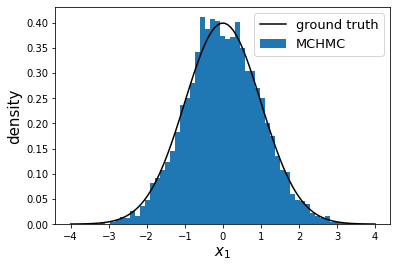

In [13]:
plt.hist(samples[:, 0], bins = 50, density = True, label = 'MCHMC')

from scipy.stats import norm

t = jnp.linspace(-4, 4, 100)
plt.plot(t, norm.pdf(t), color = 'black', label = 'ground truth')

plt.xlabel(r'$x_1$', fontsize = 15)
plt.ylabel('density', fontsize = 15)
plt.legend(fontsize = 13)
plt.show()